In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import style
%matplotlib inline 
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import seaborn as sns
sns.set(style="white", color_codes=True)
sns.set(font_scale=1.5)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import model_selection
import warnings
warnings.filterwarnings('ignore')
from imblearn.over_sampling import SMOTE


In [4]:
df_train=pd.read_csv(r'train.csv')
df_test=pd.read_csv(r'test.csv')

In [5]:
df_train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [6]:
df_train['train_flag'] = 1
df_test['train_flag'] = 0
df_test['Response'] = None
print(df_train.shape, df_test.shape)

df_data = pd.concat((df_train, df_test))
print(df_data.shape)

(381109, 13) (127037, 13)
(508146, 13)


In [7]:
df_data.drop(['id'],axis=1,inplace=True)

In [8]:
df_data['Policy_Sales_Channel'].value_counts().sort_values(ascending=False).head(10)

152.0    179523
26.0     106594
124.0     98299
160.0     29090
156.0     14313
122.0     13239
157.0      8958
154.0      7988
151.0      5271
163.0      3850
Name: Policy_Sales_Channel, dtype: int64

In [9]:
top_10=[x for x in df_data.Policy_Sales_Channel.value_counts().sort_values(ascending=False).head(10).index]
top_10

[152.0, 26.0, 124.0, 160.0, 156.0, 122.0, 157.0, 154.0, 151.0, 163.0]

In [10]:
for label in top_10:
    df_data[label]=np.where(df_data['Policy_Sales_Channel']== label, 1 ,0)

In [11]:
New=df_data[top_10]

In [12]:
New.columns

Index([152.0, 26.0, 124.0, 160.0, 156.0, 122.0, 157.0, 154.0, 151.0, 163.0], dtype='object')

In [13]:
df_data.columns

Index([              'Gender',                  'Age',      'Driving_License',
                'Region_Code',   'Previously_Insured',          'Vehicle_Age',
             'Vehicle_Damage',       'Annual_Premium', 'Policy_Sales_Channel',
                    'Vintage',             'Response',           'train_flag',
                        152.0,                   26.0,                  124.0,
                        160.0,                  156.0,                  122.0,
                        157.0,                  154.0,                  151.0,
                        163.0],
      dtype='object')

In [14]:
df_data=df_data.rename(columns={152.0: "152T", 26.0 : "26T", 124.0 : "124T" , 160.0 : "160T", 156.0 : "156T", 122.0 : "122T", 157.0 : "157T", 154.0 : "154T", 151.0 : "151T", 163.0 : "163T"})

In [15]:
df_data['Vehicle_Damage'].value_counts()

Yes    256248
No     251898
Name: Vehicle_Damage, dtype: int64

In [16]:
df_data['Gender'].replace(['Male','Female'],[0,1],inplace=True)
df_data['Vehicle_Age'].replace(['< 1 Year','1-2 Year','> 2 Years'],[1,2,3],inplace=True)
df_data['Vehicle_Damage'].replace(['No','Yes'],[0,1],inplace=True)


In [17]:
df_data.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,...,152T,26T,124T,160T,156T,122T,157T,154T,151T,163T
0,0,44,1,28.0,0,3,1,40454.0,26.0,217,...,0,1,0,0,0,0,0,0,0,0
1,0,76,1,3.0,0,2,0,33536.0,26.0,183,...,0,1,0,0,0,0,0,0,0,0
2,0,47,1,28.0,0,3,1,38294.0,26.0,27,...,0,1,0,0,0,0,0,0,0,0
3,0,21,1,11.0,1,1,0,28619.0,152.0,203,...,1,0,0,0,0,0,0,0,0,0
4,1,29,1,41.0,1,1,0,27496.0,152.0,39,...,1,0,0,0,0,0,0,0,0,0


In [18]:
df_train, df_test = df_data[df_data.train_flag == 1], df_data[df_data.train_flag == 0]
df_train.drop(['train_flag'], inplace=True, axis=1)
df_test.drop(['train_flag'], inplace=True, axis=1)
df_test.drop(['Response'], inplace=True, axis=1)

### Preparing the Training Data 
We will be using StratifiedShuffleSplit so because there is an Imbalance in the Response Classes

In [19]:
X=df_train.drop(['Response'],axis=1)
y=df_train['Response']
y=y.astype('int64')

In [20]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)


Number transactions X_train dataset:  (266776, 20)
Number transactions y_train dataset:  (266776,)
Number transactions X_test dataset:  (114333, 20)
Number transactions y_test dataset:  (114333,)


In [21]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

Before OverSampling, counts of label '1': 32618
Before OverSampling, counts of label '0': 234158 

After OverSampling, the shape of train_X: (468316, 20)
After OverSampling, the shape of train_y: (468316,) 

After OverSampling, counts of label '1': 234158
After OverSampling, counts of label '0': 234158


In [32]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train_res)
X_test = sc.transform(X_test)

In [33]:
y_train=y_train_res

In [34]:
y_train=y_train.astype('int64')


## Logistic Regression

In [35]:
# Applying logistic regression on the training set

from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

LogisticRegression()

In [36]:
y_pred = classifier.predict(X_test)

In [38]:
# Making Confusion Matrix and calculating accuracy score

mylist = []
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
ac = accuracy_score(y_test, y_pred)
mylist.append(ac)
print(cm)
print(ac)

[[51220 49021]
 [ 2647 11445]]
0.5480919769445391


In [39]:
import lightgbm as lgb
fit_params={"early_stopping_rounds":30, 
            "eval_metric" : 'auc', 
            "eval_set" : [(X_test,y_test)],
            'eval_names': ['valid'],
            #'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_099)],
            'verbose': 100,
            'categorical_feature': 'auto'}

In [40]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
param_test ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

In [41]:
#This parameter defines the number of HP points to be tested
n_HP_points_to_test = 100

import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 5000 define only the absolute maximum
clf = lgb.LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=5000)
gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=n_HP_points_to_test,
    scoring='roc_auc',
    cv=3,
    refit=True,
    random_state=314,
    verbose=True)

In [42]:
gs.fit(X_train, y_train, **fit_params)
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[27]	valid's auc: 0.810786
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[16]	valid's auc: 0.820207
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[8]	valid's auc: 0.819944
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[13]	valid's auc: 0.812122
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3]	valid's auc: 0.818788
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.818782
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[2]	valid's auc: 0.788178
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3]	valid's auc: 0.796549
Training until valida

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[4]	valid's auc: 0.819461
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[7]	valid's auc: 0.818594
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[17]	valid's auc: 0.81819
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[18]	valid's auc: 0.820336
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[18]	valid's auc: 0.820602
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[4]	valid's auc: 0.818131
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[8]	valid's auc: 0.821688
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[7]	valid's auc: 0.82104
Training until validati

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[51]	valid's auc: 0.82155
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[11]	valid's auc: 0.807788
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[4]	valid's auc: 0.813733
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[27]	valid's auc: 0.811664
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid's auc: 0.815646
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[18]	valid's auc: 0.818931
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[17]	valid's auc: 0.81889
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[27]	valid's auc: 0.819084
Training until valid

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[29]	valid's auc: 0.817554
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[25]	valid's auc: 0.818772
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[55]	valid's auc: 0.82055
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[16]	valid's auc: 0.816711
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[20]	valid's auc: 0.819931
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[23]	valid's auc: 0.820032
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid's auc: 0.818595
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[51]	valid's auc: 0.821336
Training until val

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[26]	valid's auc: 0.822505
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.820495
Early stopping, best iteration is:
[70]	valid's auc: 0.823019
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid's auc: 0.81443
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[19]	valid's auc: 0.819571
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[20]	valid's auc: 0.819583
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[5]	valid's auc: 0.818094
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[22]	valid's auc: 0.822021
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[27]	valid's auc: 

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 16.3min finished


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[4]	valid's auc: 0.820653
Best score reached: 0.942184362543918 with params: {'colsample_bytree': 0.9348023686516402, 'min_child_samples': 351, 'min_child_weight': 10.0, 'num_leaves': 47, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.49447771753795894} 


In [43]:
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

Best score reached: 0.942184362543918 with params: {'colsample_bytree': 0.9348023686516402, 'min_child_samples': 351, 'min_child_weight': 10.0, 'num_leaves': 47, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.49447771753795894} 


In [49]:
opt_parameters ={'colsample_bytree': 0.9348023686516402, 'min_child_samples': 351, 'min_child_weight': 10.0, 'num_leaves': 47, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.49447771753795894}

### Tune the weights of unbalanced classes

In [50]:
clf_sw = lgb.LGBMClassifier(**clf.get_params())
#set optimal parameters
clf_sw.set_params(**opt_parameters)

LGBMClassifier(colsample_bytree=0.9348023686516402, metric='None',
               min_child_samples=351, min_child_weight=10.0, n_estimators=5000,
               n_jobs=4, num_leaves=47, random_state=314, reg_alpha=1,
               reg_lambda=1, subsample=0.49447771753795894)

In [51]:
gs_sample_weight = GridSearchCV(estimator=clf_sw, 
                                param_grid={'scale_pos_weight':[1,2,6,12]},
                                scoring='roc_auc',
                                cv=5,
                                refit=True,
                                verbose=True)

In [52]:
gs_sample_weight.fit(X_train, y_train, **fit_params)
print('Best score reached: {} with params: {} '.format(gs_sample_weight.best_score_, gs_sample_weight.best_params_))

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[13]	valid's auc: 0.804765
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[5]	valid's auc: 0.820673
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[7]	valid's auc: 0.815295
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[8]	valid's auc: 0.815436
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[7]	valid's auc: 0.820639
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[5]	valid's auc: 0.809475
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[15]	valid's auc: 0.821027
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[25]	valid's auc: 0.82019
Training until validat

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.6min finished


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[13]	valid's auc: 0.821392
Best score reached: 0.9331566168259467 with params: {'scale_pos_weight': 2} 


### Build the final model
 We do training with the 0.8 subset of the dataset and 0.2 subset for early stopping. We use the tuned parameter values but a smaller learning rate to allow smoother convergence to the minimum

In [53]:
def learning_rate_010_decay_power_0995(current_iter): 
    base_learning_rate = 0.1 
    lr = base_learning_rate * np.power(.995, current_iter) 
    return lr if lr > 1e-3 else 1e-3

In [54]:
#Configure from the HP optimisation
#clf_final = lgb.LGBMClassifier(**gs.best_estimator_.get_params())

#Configure locally from hardcoded values
clf_final = lgb.LGBMClassifier(**clf.get_params())
#set optimal parameters
clf_final.set_params(**opt_parameters)

#Train the final model with learning rate decay
clf_final.fit(X_train, y_train, **fit_params, callbacks=[lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_0995)])

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[4]	valid's auc: 0.820653


LGBMClassifier(colsample_bytree=0.9348023686516402, metric='None',
               min_child_samples=351, min_child_weight=10.0, n_estimators=5000,
               n_jobs=4, num_leaves=47, random_state=314, reg_alpha=1,
               reg_lambda=1, subsample=0.49447771753795894)

### Plot feature importance

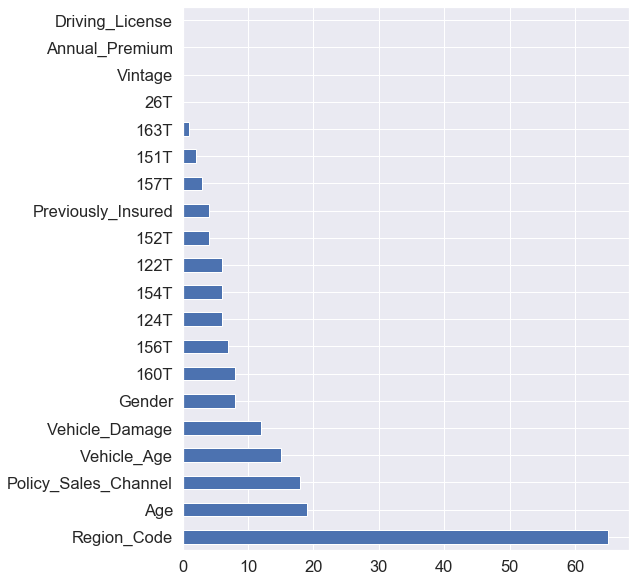

In [55]:
feat_imp = pd.Series(clf_final.feature_importances_, index=df_train.drop(['Response'], axis=1).columns)
feat_imp.nlargest(20).plot(kind='barh', figsize=(8,10))

### Preparing Test Data


In [56]:
df_test = sc.fit_transform(df_test)
df_test = sc.transform(df_test)

In [57]:
Ym=clf_final.predict(df_test)

In [58]:
Ym=pd.DataFrame(Ym)

In [59]:
Ym[0].value_counts()

0    98297
1    28740
Name: 0, dtype: int64

In [69]:
Ym=Ym.rename(columns={"Response": "Response1"})

In [61]:
sub=pd.read_csv(r'sample_submission_iA3afxn.csv')

In [62]:
sub.head()

,id,Response
0,381110,0
1,381111,0
2,381112,0
3,381113,0
4,381114,0


In [70]:
submit = pd.concat([sub,Ym],axis=1)

In [71]:
submit.head()

,id,Response,Response1
0,381110,0,0
1,381111,0,0
2,381112,0,0
3,381113,0,0
4,381114,0,0


In [72]:
sub1=submit.drop(['Response'],axis=1)

In [73]:
sub1=sub1.rename(columns={"Response1": "Response"})

In [75]:
sub.to_csv('submissionCSP.csv', index=False)